In [1]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim
import natsort
import math
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def rescale(arr, scale=255):
    arr[arr<0] = 0
    arr = arr - arr.min()
    arr = arr/arr.max()*scale
    return arr.astype(np.float32)

def T1fromMRF(MRF, regressor, model):
    device = torch.device("cuda:0")
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 256
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
        T1 = regressor(MRF[i*slice_len:(i+1)*slice_len])
        T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

# Generate MRF reconstructions

In [61]:
regressor = InceptionV4(num_classes=256)
model = "models/batch1024class256epoch10alpha0.75"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_2.npy")
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
T1_recon = T1fromMRF(MRF, regressor, model)

0
25
50
75
100
125
150
175
200
225
250
mean:  86.414912109375


In [62]:
test_arr_complex = MRF[0:500] + 1j* MRF[500:1000]

In [63]:
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
thresh = np.percentile(T1_test,95)
T1_test[T1_test>thresh] = thresh

In [64]:
# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_avg = rescale(np.abs(np.mean(test_arr_complex, 0)))

In [65]:
print(psnr(T1_recon, T1_test))
print(psnr(MRF_avg*3.2, T1_test))

15.77224026188037
14.518614852142033


In [66]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_avg*3.2, T1_test))

0.17185847618605923
0.1708783993389823


alpha 0


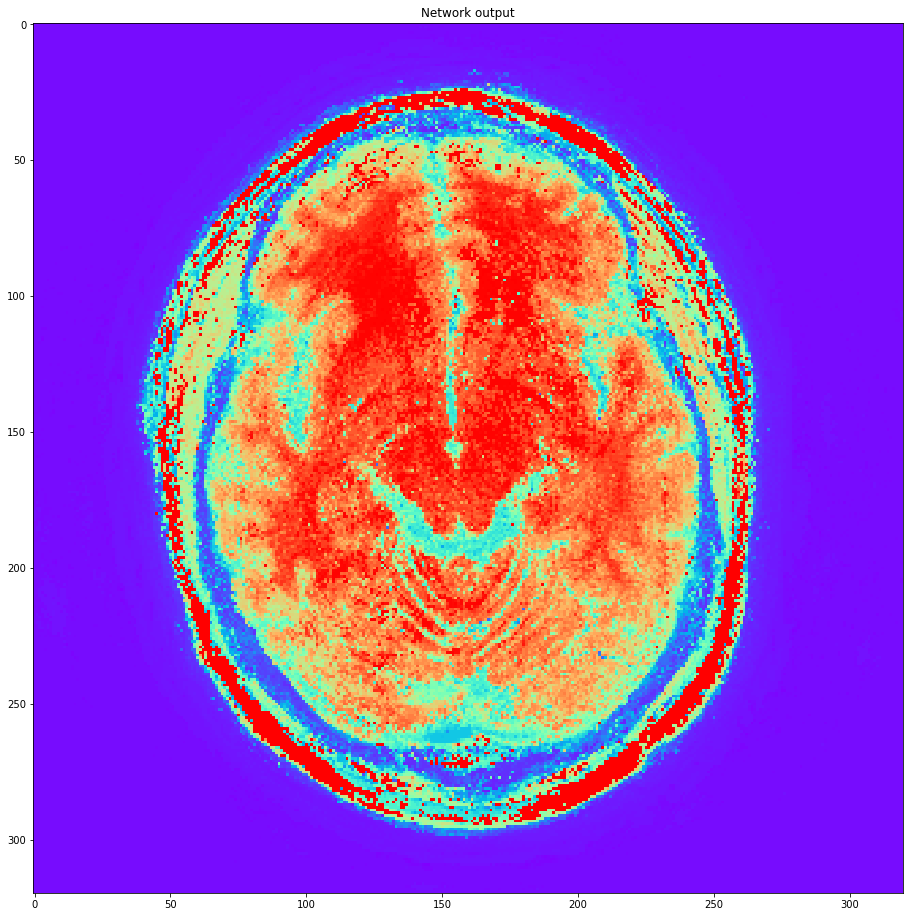

In [67]:
fig = plt.figure(figsize=(16,16))
print("alpha 0")
# plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)
plt.savefig("brainalpha0.75.png")

alpha 0


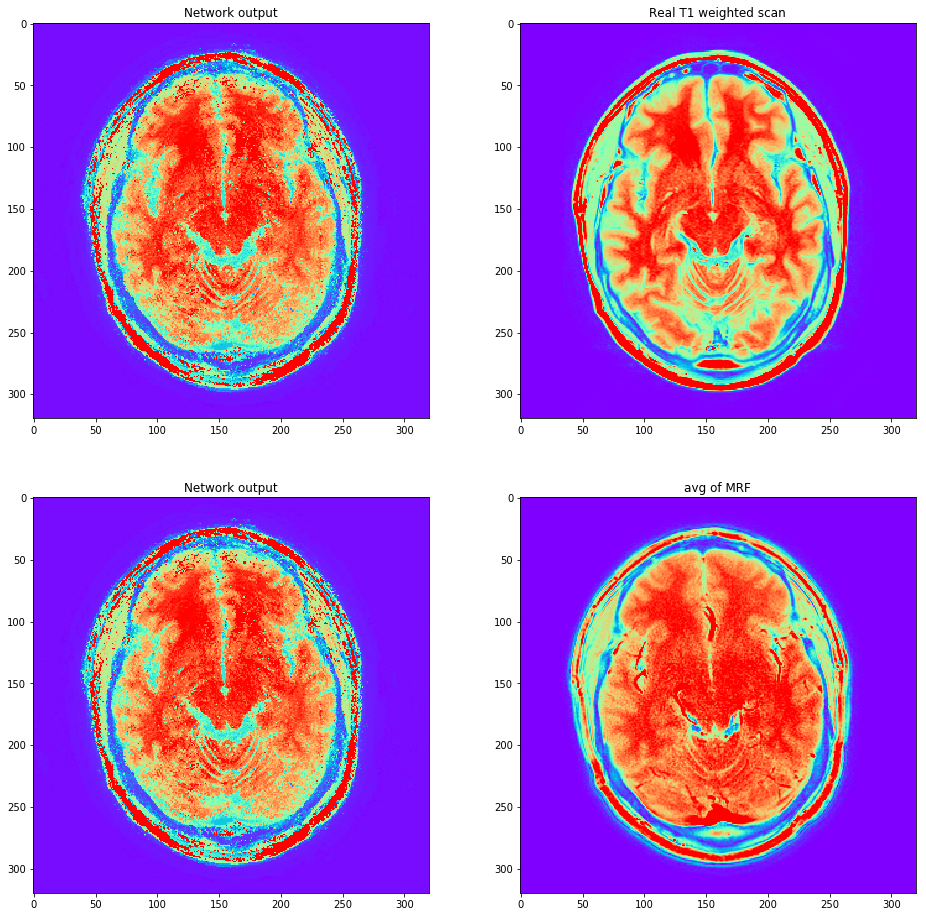

In [15]:
fig = plt.figure(figsize=(16,16))
print("alpha 0")
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_avg*3.2, cmap="rainbow",vmin=0,vmax=255)

plt.savefig("alpha0.75.png")

In [54]:
regressor = InceptionV4(num_classes=256)
model = "models/batch1024class256epoch10alpha0.2"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_2.npy")
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
T1_recon = T1fromMRF(MRF, regressor, model)

0
25
50
75
100
125
150
175
200
225
250
mean:  87.721611328125


In [55]:
test_arr_complex = MRF[0:500] + 1j* MRF[500:1000]

In [56]:
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
thresh = np.percentile(T1_test,95)
T1_test[T1_test>thresh] = thresh

In [57]:
# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_avg = rescale(np.abs(np.mean(test_arr_complex, 0)))

In [58]:
print(psnr(T1_recon, T1_test))
print(psnr(MRF_avg*3.2, T1_test))

15.789595073617924
14.518614852142033


In [59]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_avg*3.2, T1_test))

0.168199625456025
0.1708783993389823


alpha 0


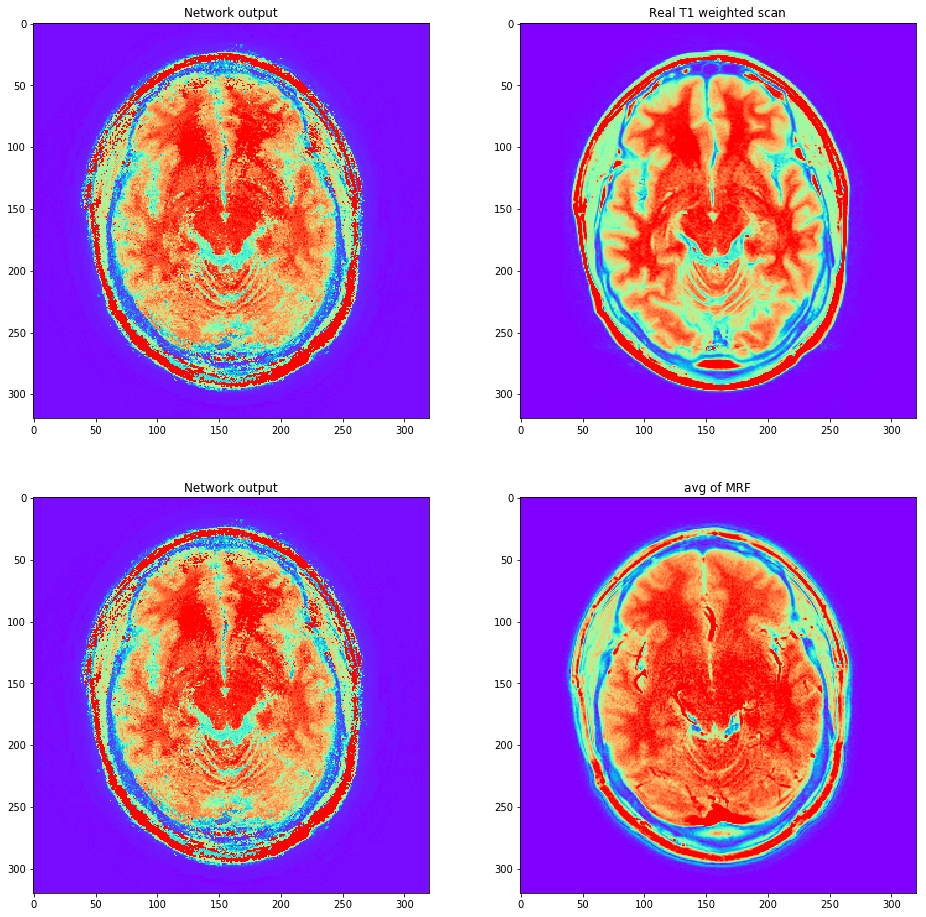

In [22]:
fig = plt.figure(figsize=(16,16))
print("alpha 0")
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_avg*3.2, cmap="rainbow",vmin=0,vmax=255)

plt.savefig("alpha0.2.png")

In [45]:
regressor = InceptionV4(num_classes=256)
model = "models/model20-21:47:04"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_2.npy")
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
T1_recon = T1fromMRF(MRF, regressor, model)

0
25
50
75
100
125
150
175
200
225
250
mean:  85.14875


In [46]:
test_arr_complex = MRF[0:500] + 1j* MRF[500:1000]

In [47]:
T1_test = np.load("/mikQNAP/augmented_data/T1w_test/T1_norm_volunteer12_2.npy")[0]
thresh = np.percentile(T1_test,95)
T1_test[T1_test>thresh] = thresh

In [48]:
# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_avg = rescale(np.abs(np.mean(test_arr_complex, 0)))

In [49]:
print(psnr(T1_recon, T1_test))
print(psnr(MRF_avg*3.2, T1_test))

15.280585257598322
14.518614852142033


In [50]:
print(ssim(T1_recon, T1_test))
print(ssim(MRF_avg*3.2, T1_test))

0.1539993232257919
0.1708783993389823


alpha 0


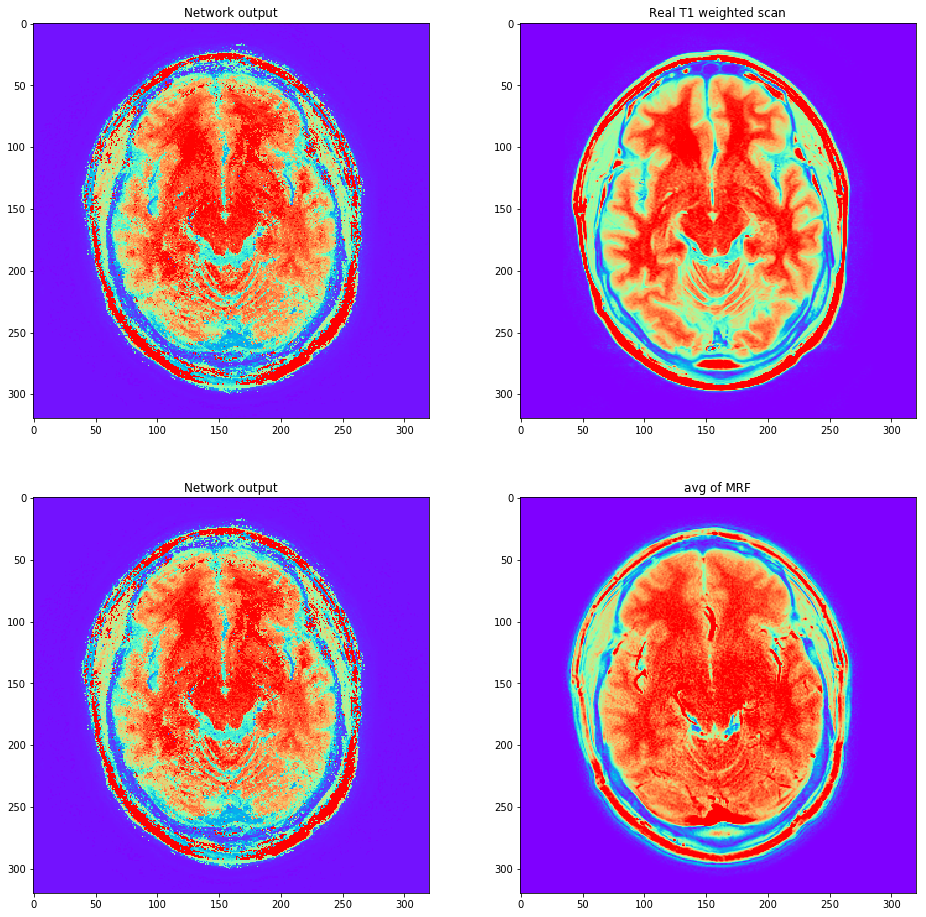

In [29]:
fig = plt.figure(figsize=(16,16))
print("alpha 0")
plt.subplot(2, 2, 1)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 2)
plt.title("Real T1 weighted scan")
plt.imshow(T1_test, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 3)
plt.title("Network output")
plt.imshow(T1_recon, cmap="rainbow",vmin=0,vmax=255)

plt.subplot(2, 2, 4)
plt.title("avg of MRF")
plt.imshow(MRF_avg*3.2, cmap="rainbow",vmin=0,vmax=255)

plt.savefig("alpha0.5.png")

# Reconstruction

In [ ]:
regressor = InceptionV4(num_classes=256)
for i in np.round(np.linspace(0,1,11),1):
    model = "models/alpha" + str(i)
    for j in range(1,11):
        MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(j) + ".npy")
        T1_recon = T1fromMRF(MRF, regressor, model)
        np.save("outputs/alpha" + str(i) + "trial" + str(j), T1_recon)

# Compare Reconstructions

In [65]:
testnames = natsort.natsorted(glob.glob("/mikQNAP/augmented_data/T1w/*"))
testnames = testnames[-41:-1]

In [66]:
filenames = np.array(natsort.natsorted(glob.glob("outputs/*")))
filenames = filenames.reshape(-1,40)

In [67]:
ssims = []
psnrs = []
for category in filenames:
    for filename, testname in zip(category, testnames):
        recon = np.load(filename)
        test = np.load(testname)[0]
        ssims.append(ssim(rescale(recon),rescale(test)))
        psnrs.append(psnr(rescale(recon),rescale(test)))


In [68]:
alphas = np.round(np.linspace(0,1,11),1)
alphas_repeat = np.repeat(alphas, 40)
ssims_array = np.array(ssims).reshape(-1,40)
psnrs_array = np.array(psnrs).reshape(-1,40)

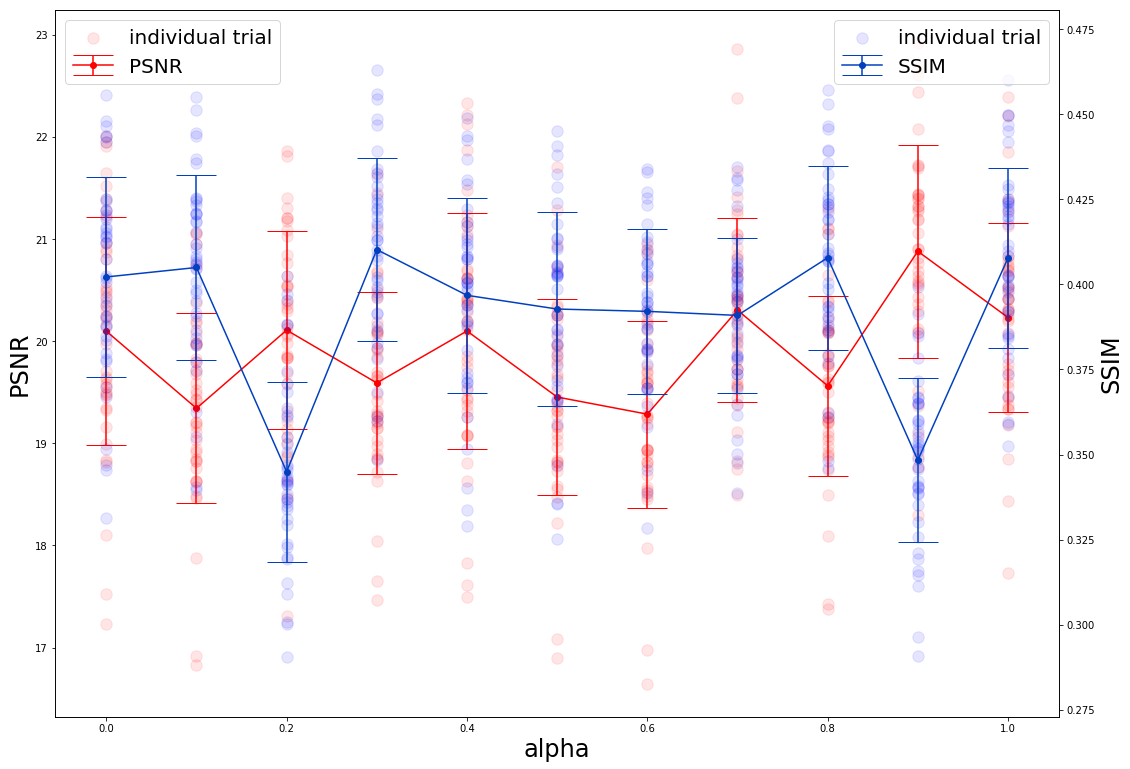

In [69]:
fig1, ax1 = plt.subplots()
fig1.set_figheight(13)
fig1.set_figwidth(18)
ax1.scatter(alphas_repeat, psnrs, s=130, alpha=0.1,c="red", label="individual trial")
ax1.set_ylabel("PSNR", fontsize=24)
ax1.errorbar(alphas, np.mean(psnrs_array, axis=1), np.std(psnrs_array, axis=1), marker='o', c=(1,0,0), capsize=20, label="PSNR")
ax1.set_xlabel("alpha", fontsize=24)

ax2 = ax1.twinx()

ax2.scatter(alphas_repeat, ssims, s=130, alpha=0.1,c="blue", label="individual trial")
ax2.set_ylabel("SSIM", fontsize=24)
ax2.errorbar(alphas, np.mean(ssims_array, axis=1), np.std(ssims_array, axis=1), marker='o', c=(0,0.25,0.75), capsize=20, label="SSIM")

ax1.legend(loc=2, prop={'size': 20})
ax2.legend(loc=1, prop={'size': 20})

# ax1.set_xlabel("Number of Points",  fontsize=23)
# ax1.set_ylabel("Overall Accuracy", fontsize=23)
# ax1.tick_params(labelsize=20)

# ax1.set_xscale('log')
# ax1.set_xticks([20, 40, 80,160,320,640,1280,2560,5120])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())